# FINM 33150: Quantitative Trading Strategies Homework 4, Market Flow and Trading Opportunity
#### Author: Joshua Weekes
#### Due Date: 2/8/2024

#### Sections:

1. Introduction

2. Package Imports

3. Helper Functions

4. Data Import

5. Data Preprocess

6. Process Data and Calculate Parameters and Metrics

7. Final Parameter Selection

8. Trading Algorithm Logic

9. Results

10. Analysis

11. Conclusion

# Introduction

The purpose of this notebook is to become familiar with analyzing tick data. I will be calculating past trade flow over an interval of tau seconds and regressing it against future returns over T seconds to help drive a trading strategy that predicts future returns and either buys or sells a crypto pair when the predicted gain or loss is higher than some value j. I will be algorithmically choosing 9 different tau T pairs per crypto pair and algorithmically choosing 3 js per pair by the percentile of the regression beta times the trade flow over the training data set. I will also be selecting my final tau T pair to use for the trading strategy based on their in sample r^2 value. After I will calculate performance metrics of the trading strategy and give the results of the total capital over time and profit and loss over time and per tick. I will choose the starting capital by twice the highest volume over the test period and I will be sizing the trades to be 5% of what was traded at that tick.

# Package Imports

In [6]:
import os
import pandas as pd
import numpy as np
import quandl
from matplotlib import pyplot as plt
from matplotlib import dates
import seaborn as sns
import statsmodels.api as sm
from datetime import date
import datetime
import functools
import random
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

us_business_day = CustomBusinessDay(calendar=USFederalHolidayCalendar())

# global api_key
# api_key = 'ykKjRrdMDZk8sVyrhPEV'
# start_date_str = '2016-01-01'
# end_date_str = '2023-06-30'
# start_date = datetime.datetime.strptime(start_date_str, '%Y-%m-%d')
# end_date = datetime.datetime.strptime(end_date_str, '%Y-%m-%d')

# Helper Functions

In [7]:
def adjust_intervals_based_on_data_density(df, time_diffs, target_coverage=[20, 30, 50]):
    """
    Suggests 3 intervals based on ensuring the average amount of timestamps covered by the interval being >= [20, 30, 50].
    The intervals are chosen based on the data distribution and are all integers, rounding up if necessary.
    
    Parameters:
    - df: DataFrame with timestamps as the index.
    - target_coverage: List of targets for average amount of timestamps covered by the intervals.
    
    Returns:
    - A list of 3 Flow Intervals, as integers.
    """
    # Initialize a list to store the calculated intervals
    calculated_intervals = []
    
    # For each target coverage, find the smallest interval that covers at least the target number of timestamps on average
    for target in target_coverage:
        # Calculate cumulative sum and use it to find the interval
        for interval in range(1, int(time_diffs.max()) + 1):
            # Calculate how many timestamps would be covered on average by this interval
            coverage = time_diffs[time_diffs <= interval].count() / (df.index.max() - df.index.min()).total_seconds() * interval
            if coverage >= target:
                calculated_intervals.append(interval)
                break
    
    # Ensure all intervals are at least 1 second
    calculated_intervals = [max(1, interval) for interval in calculated_intervals]
    
    return calculated_intervals

def calculate_forecast_intervals(intervals):
    """
    Takes a list of intervals and returns intervals that are 1, 1.5, and 2 times the magnitude of the intervals,
    ensuring the forecast intervals are integers.
    
    Parameters:
    - intervals: The list of intervals.
    
    Returns:
    - A list of forecast intervals, adjusted as described.
    """
    forecast_intervals = []
    for interval in intervals:
        forecast_intervals.extend([int(np.ceil(interval * multiplier)) for multiplier in [1, 1.5, 2]])
    
    return forecast_intervals

def calculate_and_suggest_intervals(dataframes_dict, timestamp_col='timestamp_utc'):
    """
    Calculate, print, and return the suggested analysis intervals and forecast intervals
    for multiple DataFrames based on the density of timestamps.
    
    Parameters:
    - dataframes_dict: A dictionary with placeholders as keys and DataFrame objects as values.
    - timestamp_col: The column name containing datetime values.
    
    Returns:
    - A dictionary with DataFrame placeholders as keys and a tuple of suggested intervals
      and forecast intervals as values.
    """
    intervals_dict = {}
    for placeholder, df in dataframes_dict.items():
        # Ensure the timestamp column is in datetime format
        df.index = pd.to_datetime(df[timestamp_col])
        df = df.sort_index()
        df = df.drop(columns=[timestamp_col])

        # Calculate time differences in seconds between consecutive timestamps
        time_diffs = df.index.to_series().diff().dt.total_seconds().dropna()

        # Suggest intervals based on the distribution of time differences
        flow_intervals = adjust_intervals_based_on_data_density(df, time_diffs)

        # Calculate forecast intervals based on the Flow Intervals
        forecast_intervals = calculate_forecast_intervals(flow_intervals)

        # Update results dictionary
        intervals_dict[placeholder] = {
            'Flow Intervals': flow_intervals,
            'Forecast Intervals': forecast_intervals
        }

        # Print suggested intervals and forecast intervals
        print(f"Flow intervals for {placeholder}: {flow_intervals} seconds")
        print(f"Forecast intervals for {placeholder}: {forecast_intervals} seconds")
    
    return intervals_dict

def check_mixed_sides(df):
    """
    Check if there are any dates with mixed sides in the high-frequency trade data.

    Parameters:
    - df: DataFrame containing high-frequency trade data.

    Returns:
    - Tuple of a boolean indicating if there are any mixed sides, and the count of mixed side dates.
    """
    # Group by date and determine if any date has mixed sides
    mixed_sides = df.groupby('timestamp_utc')['Side'].apply(lambda x: not (x.gt(0).all() or x.lt(0).all()))
    mixed_count = mixed_sides.sum()  # Count of True values indicates mixed sides
    
    # Check if there are any mixed side dates
    has_mixed_sides = mixed_count > 0
    
    return has_mixed_sides, mixed_count

def get_test_train_dates(df):
    """
    Split the unique dates into train and test sets based on a 40/60 split.

    Parameters:
    - df: DataFrame containing high-frequency trade data.

    Returns:
    - Tuple of train and test dates.
    """
    unique_dates = df['timestamp'].unique()
    split_index = int(len(unique_dates) * 0.4)
    train_dates = unique_dates[:split_index]
    test_dates = unique_dates[split_index:]
    return train_dates, test_dates

def process_dataframes(df):
    """
    Process the dataframes to calculate the net size and side for each date, and split into train and test sets,

    Parameters:
    - df: DataFrame containing high-frequency trade data.

    Returns:
    - Tuple of DataFrames for train and test sets.
    """
    # Constants for conversions
    billionths_conversion = 10**9
    millionths_conversion = 10**6

    df = df.rename(columns= {'timestamp_utc': 'timestamp'})
    
    # Adjust size and price columns using vectorized operations
    df['size'] = df['SizeBillionths'] / billionths_conversion
    df['price'] = df['PriceMillionths'] / millionths_conversion
    
    # Adjust the volume based on the side, vectorized
    df['adjusted_size'] = df['Side'].apply(lambda x: -1 if x < 0 else 1) * df['size']
    
    # Calculate weighted price (swap) before grouping to avoid repeated sum calculations
    df['weighted_price'] = df['price'] * df['adjusted_size'].abs()
    
    # Group by date to calculate the net size and weighted price for swap calculation
    grouped = df.groupby('timestamp_utc').agg(
        net_size=('adjusted_size', 'sum'),
        total_weighted_price=('weighted_price', 'sum'),
        total_abs_size=('adjusted_size', lambda x: x.abs().sum()),
    ).reset_index()
    
    # Calculate swap using aggregated values
    grouped['swap'] = grouped['total_weighted_price'] / grouped['total_abs_size']
    
    # Calculate the absolute size and determine the side based on net_size, vectorized
    grouped['size'] = grouped['net_size'].abs()
    grouped['side'] = grouped['net_size'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    
    # Drop unnecessary columns
    grouped.drop(columns=['net_size', 'total_weighted_price', 'total_abs_size'], inplace=True)
    
    # Get train and test dates (assuming this function is efficient as mentioned)
    train_dates, test_dates = get_test_train_dates(df)
    
    # Split into train and test DataFrames based on the dates
    train_df = grouped[grouped['timestamp_utc'].isin(train_dates)].set_index('timestamp_utc')
    test_df = grouped[grouped['timestamp_utc'].isin(test_dates)].set_index('timestamp_utc')
    
    # Keeping relevant columns
    train_df = train_df[['swap', 'size', 'side']]
    test_df = test_df[['swap', 'size', 'side']]
    
    return train_df, test_df


def calculate_forward_returns(df, forecast_T):
    """
    Calculate forward returns for non-uniformly spaced high-frequency data.
    Accurately finds the closest future timestamp within the specified interval T.

    Parameters:
    - df: DataFrame containing high-frequency trade data.
    - intervalswxa_T: Time interval for forward returns calculation in seconds.

    Returns:
    - Series with forward returns for the specified interval.
    """
    # Ensure DataFrame is sorted by index
    df.sort_index(inplace=True)
    
    # Convert the DataFrame index to numpy array for efficient computation
    timestamps = df.index.values  # DatetimeIndex to numpy array
    prices = df['swap'].values  # Price values to numpy array
    
    try:
        forecast_T = float(forecast_T)
    except ValueError:
        raise ValueError(f"interval_T must be numeric, got {type(forecast_T)} with value {forecast_T}")
    
    # Proceed with the function assuming interval_T is now correctly a float
    interval_ns = np.timedelta64(int(forecast_T * 1e9), 'ns')  # Convert seconds to nanoseconds
    
    forward_returns = np.zeros_like(prices)  # Initialize forward returns array
    
    # Iterate over timestamps to calculate forward returns
    for i, current_time in enumerate(timestamps[:-1]):  # Exclude the last timestamp
        # Find the index of the first timestamp beyond the current_time + interval_ns
        future_idx = np.searchsorted(timestamps, current_time + interval_ns, side='left')
        
        if future_idx < len(prices):
            future_price = prices[future_idx]
            current_price = prices[i]
            forward_returns[i] = (future_price - current_price) / current_price
        else:
            forward_returns[i] = np.nan  # Assign NaN if no future price is found within the interval
    
    # Convert forward returns array back to pandas Series with the same index as the DataFrame
    forward_returns_series = pd.Series(forward_returns, index=df.index)
    
    return forward_returns_series

def calculate_trade_flow(df, interval_T):
    """
    Calculate trade flow using rolling windows, adjusted for sub-second intervals.

    Parameters:
    - df: DataFrame containing high-frequency trade data.
    - interval_T: Time interval for forward returns and trade flow calculations.

    Returns:
    - Series with trade flow for the specified interval.
    """
    # Assuming 'size' is already adjusted by side (positive for buys, negative for sells)
    df['signed_size'] = df['size'] * df['side']

    # For sub-second intervals, ensure the interval is specified as a Timedelta that pandas can handle
    window = pd.to_timedelta(interval_T, unit='s')
    
    # Use rolling window based on time to sum signed sizes
    trade_flow = df['signed_size'].rolling(window=window).sum()
    
    return trade_flow

def calculate_all_metrics(dataframes_dict, intervals_dict):
    """
    Calculate trade flow and forward returns for each combination of intervals,
    and store the results in a nested dictionary.

    Parameters:
    - dataframes_dict: Dictionary structured with placeholders as keys and DataFrame objects as values.
    - intervals_dict: Dictionary structured with placeholders as keys and nested dictionaries containing
                      Flow Intervals and Forecast Intervals as values.
    
    Returns:
    - A dictionary with placeholders as keys and nested dictionaries containing the calculated metrics.
    """
    metrics_dict = {}
    for placeholder, df in dataframes_dict.items():
        flow_metrics = []
        forecast_metrics = []
        
        # Calculate trade flow metrics for each flow interval
        for flow_interval in intervals_dict[placeholder]['Flow Intervals']:
            flow_series = calculate_trade_flow(df, flow_interval)
            flow_metrics.append((flow_interval, flow_series))
        
        # Calculate forward returns for each forecast interval
        for forecast_interval in intervals_dict[placeholder]['Forecast Intervals']:
            forecast_series = calculate_forward_returns(df, forecast_interval)
            forecast_metrics.append((forecast_interval, forecast_series))
        
        metrics_dict[placeholder] = {
            'flow_metrics': flow_metrics,
            'forecast_metrics': forecast_metrics
        }
    
    combined_metrics_dict = combine_metrics_into_dataframes(metrics_dict, dataframes_dict)

    return combined_metrics_dict

def combine_metrics_into_dataframes(metrics_dict, dataframes_dict):
    combined_dataframes_dict = {}

    for placeholder in metrics_dict:
        combined_dataframes_dict[placeholder] = {}
        placeholder_df = dataframes_dict[placeholder]
        
        # Select the relevant columns from the placeholder DataFrame
        relevant_columns_df = placeholder_df[['size', 'swap', 'side']].copy()

        flow_metrics = metrics_dict[placeholder]['flow_metrics']
        forecast_metrics = metrics_dict[placeholder]['forecast_metrics']
        
        # Define the range for each flow interval to match with forecast intervals
        forecast_interval_ranges = {
            0: forecast_metrics[0:3],  # First flow interval with the first 3 forecast intervals
            1: forecast_metrics[3:6],  # Second flow interval with the next 3 forecast intervals
            2: forecast_metrics[6:9]   # Third flow interval with the last 3 forecast intervals
        }
        
        # Iterate over flow intervals
        for i, (flow_interval, flow_series) in enumerate(flow_metrics):
            # Match each flow interval with its corresponding forecast intervals
            for forecast_interval, forecast_series in forecast_interval_ranges[i]:
                # Merge relevant columns with flow and forecast metrics
                combined_df = pd.DataFrame({
                    'trade_flow': flow_series,
                    'forward_returns': forecast_series
                }).join(relevant_columns_df, how='inner').dropna()
                
                # Naming convention to identify the combination
                interval_key = f"Flow_{flow_interval}_Forecast_{forecast_interval}"
                combined_dataframes_dict[placeholder][interval_key] = combined_df
                
    return combined_dataframes_dict

def run_regressions(metrics_dict):
    """
    Run linear regressions for each combination of trade_flow and forward_returns intervals,
    and store the beta coefficients, R-squared, and MSE for each regression.

    Parameters:
    - metrics_dict: Dictionary structured with placeholders as keys and nested dictionaries containing
                    combined dataframes for 'trade_flow' and 'forward_returns' as values.
    
    Returns:
    - Two dictionaries: one for the beta coefficients and another for R-squared and MSE values.
    """
    beta_dict = {}
    performance_dict = {}
    
    for placeholder, intervals_data in metrics_dict.items():
        beta_dict[placeholder] = {}
        performance_dict[placeholder] = {}
        
        for interval_key, df in intervals_data.items():
            # Ensure data is aligned and drop any NaNs
            df = df.dropna()
            X = df[['trade_flow']]
            y = df['forward_returns']
            
            if not X.empty and not y.empty:
                model = LinearRegression().fit(X, y)
                y_pred = model.predict(X)
                
                # Store beta coefficient
                beta_dict[placeholder][interval_key] = model.coef_[0]
                
                # Calculate and store R-squared and MSE
                performance_dict[placeholder][interval_key] = {
                    'R2': r2_score(y, y_pred),
                    'MSE': mean_squared_error(y, y_pred)
                }
    
    return beta_dict, performance_dict

def find_j_values(metrics_dict, beta_dict):
    """
    Find j values based on the regression beta coefficients and the trade flow from metrics_dict,
    for specified percentiles.

    Parameters:
    - metrics_dict: Dictionary structured with placeholders as keys and nested dictionaries
                    containing combined dataframes for 'trade_flow' and 'forward_returns'.
    - beta_dict: Dictionary containing the beta coefficients from the regression results.

    Returns:
    - A dictionary with placeholders as keys and sub-dictionaries containing the j values for
      each combination of trade flow and forward return intervals at specified percentiles.
    """
    j_values_dict = {}
    percentages = [0.30, 0.50, 0.70]

    for placeholder, intervals_data in metrics_dict.items():
        j_values_dict[placeholder] = {}

        for interval_key, df in intervals_data.items():
            # Ensure alignment and drop any NaNs
            df = df.dropna()
            if interval_key in beta_dict[placeholder]:
                beta = beta_dict[placeholder][interval_key]
                
                # Calculate the absolute product of trade_flow and beta
                abs_product = abs(df['trade_flow'] * beta)
                
                # Compute j values for specified percentiles
                j_values = {f'{int(pct * 100)}_percentile': abs_product.quantile(1 - pct) for pct in percentages}
                
                # Store j values for this interval combination
                j_values_dict[placeholder][interval_key] = j_values

    return j_values_dict

# Data Import

In [8]:
btc_usd_trades_df = pd.read_csv(r'data\crypto\trades_narrow_BTC-USD_2023.delim', delimiter='\t')
btc_usd_trades_df = btc_usd_trades_df.drop(columns=['received_utc_nanoseconds'])
btc_usd_trades_df['timestamp_utc_nanoseconds'] = pd.to_datetime(btc_usd_trades_df['timestamp_utc_nanoseconds'], unit='ns')
btc_usd_trades_df = btc_usd_trades_df.rename(columns={'timestamp_utc_nanoseconds': 'timestamp_utc'})
btc_usd_trades_df.head()

,timestamp_utc,PriceMillionths,SizeBillionths,Side
0,2023-01-24 00:47:47.874527,22970120000,87069600,-1
1,2023-01-24 00:47:47.874527,22970150000,25797600,-1
2,2023-01-24 00:47:47.878712,22970120000,10,-1
3,2023-01-24 00:47:47.886114,22969160000,217683140,-1
4,2023-01-24 00:47:48.676444,22969840000,10000000,1


In [9]:
eth_btc_trades_df = pd.read_csv(r'data\crypto\trades_narrow_ETH-BTC_2023.delim', delimiter='\t')
eth_btc_trades_df = eth_btc_trades_df.drop(columns=['received_utc_nanoseconds'])
eth_btc_trades_df['timestamp_utc_nanoseconds'] = pd.to_datetime(eth_btc_trades_df['timestamp_utc_nanoseconds'], unit='ns')
eth_btc_trades_df = eth_btc_trades_df.rename(columns={'timestamp_utc_nanoseconds': 'timestamp_utc'})
eth_btc_trades_df.head()

,timestamp_utc,PriceMillionths,SizeBillionths,Side
0,2023-01-24 00:49:06.020758,70950,259656510,1
1,2023-01-24 00:49:06.050573,70950,140800,1
2,2023-01-24 00:49:08.159815,70950,53582550,-1
3,2023-01-24 00:49:12.601911,70940,207220,-1
4,2023-01-24 00:52:26.201920,70950,990630,1


In [10]:
eth_usd_trades_df = pd.read_csv(r'data\crypto\trades_narrow_ETH-USD_2023.delim', delimiter='\t')
eth_usd_trades_df = eth_usd_trades_df.drop(columns=['received_utc_nanoseconds'])
eth_usd_trades_df['timestamp_utc_nanoseconds'] = pd.to_datetime(eth_usd_trades_df['timestamp_utc_nanoseconds'], unit='ns')
eth_usd_trades_df = eth_usd_trades_df.rename(columns={'timestamp_utc_nanoseconds': 'timestamp_utc'})
eth_usd_trades_df.head()

,timestamp_utc,PriceMillionths,SizeBillionths,Side
0,2023-01-24 00:47:51.071902,1629670000,11815210,-1
1,2023-01-24 00:47:51.398509,1629770000,92158690,1
2,2023-01-24 00:47:51.398509,1629780000,712594890,2
3,2023-01-24 00:47:51.398509,1629790000,1016994240,2
4,2023-01-24 00:47:51.578052,1629770000,92150000,1


# Pre-Processing Data

In [11]:
print(f'BTC-USD: Trades length: {len(btc_usd_trades_df)}, Trades only contains unique timestamps: {btc_usd_trades_df["timestamp_utc"].is_unique}')
print(f'ETH-USD: Trades length: {len(eth_usd_trades_df)}, Trades only contains unique timestamps: {eth_usd_trades_df["timestamp_utc"].is_unique}')
print(f'ETH-BTC: Trades length: {len(eth_btc_trades_df)}, Trades only contains unique timestamps: {eth_btc_trades_df["timestamp_utc"].is_unique}')

BTC-USD: Trades length: 560107, Trades only contains unique timestamps: False
ETH-USD: Trades length: 377185, Trades only contains unique timestamps: False
ETH-BTC: Trades length: 1958, Trades only contains unique timestamps: False


In [12]:
# print(f'BTC-USD: Book start: {btc_usd_book_df["timestamp_utc"].min()}, Book end: {btc_usd_book_df["timestamp_utc"].max()}')
# print(f'ETH-USD: Book start: {eth_usd_book_df["timestamp_utc"].min()}, Book end: {eth_usd_book_df["timestamp_utc"].max()}')
# print(f'ETH-BTC: Book start: {eth_btc_book_df["timestamp_utc"].min()}, Book end: {eth_btc_book_df["timestamp_utc"].max()}')

print(f'BTC-USD: Trades start: {btc_usd_trades_df["timestamp_utc"].min()}, Trades end: {btc_usd_trades_df["timestamp_utc"].max()}')
print(f'ETH-USD: Trades start: {eth_usd_trades_df["timestamp_utc"].min()}, Trades end: {eth_usd_trades_df["timestamp_utc"].max()}')
print(f'ETH-BTC: Trades start: {eth_btc_trades_df["timestamp_utc"].min()}, Trades end: {eth_btc_trades_df["timestamp_utc"].max()}')

BTC-USD: Trades start: 2023-01-24 00:47:47.874527, Trades end: 2023-01-25 15:50:01.601767
ETH-USD: Trades start: 2023-01-24 00:47:51.071902, Trades end: 2023-01-25 15:00:30.376266
ETH-BTC: Trades start: 2023-01-24 00:49:06.020758, Trades end: 2023-01-25 15:08:05.145749


In [13]:
btc_usd_mixed_sides, btc_usd_mixed_count = check_mixed_sides(btc_usd_trades_df)
eth_usd_mixed_sides, eth_usd_mixed_count = check_mixed_sides(eth_usd_trades_df)
eth_btc_mixed_sides, eth_btc_mixed_count = check_mixed_sides(eth_btc_trades_df)

print(f'BTC-USD: Mixed sides: {btc_usd_mixed_sides}, Count: {btc_usd_mixed_count}')
print(f'ETH-USD: Mixed sides: {eth_usd_mixed_sides}, Count: {eth_usd_mixed_count}')
print(f'ETH-BTC: Mixed sides: {eth_btc_mixed_sides}, Count: {eth_btc_mixed_count}')

BTC-USD: Mixed sides: True, Count: 7
ETH-USD: Mixed sides: True, Count: 5
ETH-BTC: Mixed sides: False, Count: 0


In [14]:
df_dict = {
    "BTC-USD": btc_usd_trades_df,
    "ETH-USD": eth_usd_trades_df,
    "ETH-BTC": eth_btc_trades_df
}

interval_results = calculate_and_suggest_intervals(df_dict)
interval_results

Flow intervals for BTC-USD: [6, 8, 13] seconds
Forecast intervals for BTC-USD: [6, 9, 12, 8, 12, 16, 13, 20, 26] seconds
Flow intervals for ETH-USD: [8, 11, 19] seconds
Forecast intervals for ETH-USD: [8, 12, 16, 11, 17, 22, 19, 29, 38] seconds
Flow intervals for ETH-BTC: [1434, 2145, 3528] seconds
Forecast intervals for ETH-BTC: [1434, 2151, 2868, 2145, 3218, 4290, 3528, 5292, 7056] seconds


{'BTC-USD': {'Flow Intervals': [6, 8, 13],
  'Forecast Intervals': [6, 9, 12, 8, 12, 16, 13, 20, 26]},
 'ETH-USD': {'Flow Intervals': [8, 11, 19],
  'Forecast Intervals': [8, 12, 16, 11, 17, 22, 19, 29, 38]},
 'ETH-BTC': {'Flow Intervals': [1434, 2145, 3528],
  'Forecast Intervals': [1434,
   2151,
   2868,
   2145,
   3218,
   4290,
   3528,
   5292,
   7056]}}

# Process Data and Calculate Metrics and Parameters

In [15]:
btc_usd_train_df, btc_usd_test_df = process_dataframes(btc_usd_trades_df)
eth_btc_train_df, eth_btc_test_df = process_dataframes(eth_btc_trades_df)
eth_usd_train_df, eth_usd_test_df = process_dataframes(eth_usd_trades_df)

In [16]:
# btc_usd_train_df.head()

In [17]:
train_dfs = {
    "BTC-USD": btc_usd_train_df,
    "ETH-USD": eth_usd_train_df,
    "ETH-BTC": eth_btc_train_df
}

In [18]:
train_metrics_dict = calculate_all_metrics(train_dfs, interval_results)

In [19]:
regression_results, regression_stats = run_regressions(train_metrics_dict)

In [20]:
j_value_dict = find_j_values(train_metrics_dict, regression_results)

# Final Parameter Selection

In [21]:
def find_max_r2(regression_stats):
    max_r2 = 0
    max_r2_key = None
    for key, value2 in regression_stats.items():
        if value2['R2'] > max_r2:
            max_r2 = value2['R2']
            max_r2_key = key
    return max_r2, max_r2_key

In [22]:
btc_usd_optimal_r2, btc_usd_optimal_key = find_max_r2(regression_stats['BTC-USD'])
eth_btc_optimal_r2, eth_btc_optimal_key = find_max_r2(regression_stats['ETH-BTC'])
eth_usd_optimal_r2, eth_usd_optimal_key = find_max_r2(regression_stats['ETH-USD'])

In [23]:
print(f'BTC-USD: Optimal R2: {btc_usd_optimal_r2}, Optimal Key: {btc_usd_optimal_key}')
print(f'ETH-BTC: Optimal R2: {eth_btc_optimal_r2}, Optimal Key: {eth_btc_optimal_key}')
print(f'ETH-USD: Optimal R2: {eth_usd_optimal_r2}, Optimal Key: {eth_usd_optimal_key}')

BTC-USD: Optimal R2: 0.0016986134523711005, Optimal Key: Flow_13_Forecast_26
ETH-BTC: Optimal R2: 0.2130194638197752, Optimal Key: Flow_2145_Forecast_3218
ETH-USD: Optimal R2: 0.0019266409747376034, Optimal Key: Flow_8_Forecast_8


In [24]:
key_list = [btc_usd_optimal_key, eth_btc_optimal_key, eth_usd_optimal_key]

In [25]:
trade_interval_dict = {
    "BTC-USD": {"Flow Intervals": [13], "Forecast Intervals": [26]},
    "ETH-USD": {"Flow Intervals": [8], "Forecast Intervals": [8]},
    "ETH-BTC": {"Flow Intervals": [2145], "Forecast Intervals": [3218]}
    }

#### Function to remove non ideal parameters

In [26]:
def convert_dictionaries(dictionary, key_list):
    new_dict = {}
    for placeholder in dictionary.keys():
        new_dict[placeholder] = {}
        for key in key_list:
            try:
                new_dict[placeholder][key] = dictionary[placeholder][key]
            except:
                pass
    return new_dict
    

In [27]:
trade_j_dict = convert_dictionaries(j_value_dict, key_list)

# Trading Algorithm

In [28]:
class NewTradeFlowAnalysisStrategy:
    def __init__(self, starting_capital, trade_size_percentage, size_multiplier, combined_metrics_dict, intervals_dict, j_values_dict, beta_dict):
        self.starting_capital = starting_capital
        self.trade_size_percentage = trade_size_percentage
        self.size_multiplier = size_multiplier
        self.combined_metrics_dict = combined_metrics_dict
        self.intervals_dict = intervals_dict
        self.j_values_dict = j_values_dict
        self.beta_dict = beta_dict
        self.trade_summaries = {}
        self.tick_performance_tracker = {}

    def execute_trades(self):
        for placeholder, dataframes in self.combined_metrics_dict.items():
            self.trade_summaries[placeholder] = {}
            self.tick_performance_tracker[placeholder] = {}
            for interval_key, df in dataframes.items():
                beta = self.beta_dict[placeholder][interval_key]
                
                for percentile_key, j_value in self.j_values_dict[placeholder][interval_key].items():
                    capital = self.starting_capital
                    trades = []
                    position_open = False
                    current_position_value = 0
                    performance_tracker = []
                    
                    for timestamp, row in df.iterrows():
                        beta_trade_flow = beta * row['trade_flow']
                        # trade_size = self.trade_size_percentage * self.size_multiplier * row['size']
                        # trade_size = trades[-1]["size"]
                        # position_value = trade_size * row['swap']
                        
                        # Determine the action based on beta*trade_flow and j_value
                        if beta_trade_flow > j_value:
                            action = "long"
                        elif beta_trade_flow < -j_value:
                            action = "short"
                        else:
                            action = "close"

                        trade_size = trades[-1]["size"] if position_open else self.trade_size_percentage * self.size_multiplier * row['size']
                        position_value = trade_size * row['swap']
                        
                        # Update continuous P&L for an open position
                        if position_open and trades[-1]["action"] != "long":
                            # Calculate P&L for the current position
                            pnl = position_value - current_position_value
                            capital += pnl  # Adjust capital for the P&L
                            trades[-1]["pnl"] += pnl  # Update the cumulative P&L for the open position
                            trades[-1]["current_value"] = position_value
                        elif position_open and trades[-1]["action"] == "short":
                            # Calculate P&L for the current position
                            pnl = current_position_value - position_value
                            capital += pnl
                            trades[-1]["pnl"] += pnl  # Update the cumulative P&L for the open position
                            trades[-1]["current_value"] = position_value
                        
                        # Manage positions based on the action
                        if action in ["long", "short"]:
                            # trade_size = self.trade_size_percentage * self.size_multiplier * row['size']
                            position_value = trade_size * row['swap']
                            if position_open and action != trades[-1]["action"]:
                                # Close the current position and open a new one in the opposite direction
                                trades[-1]["close_price"] = row['swap']
                                last_open_date = timestamp
                                trades.append({"action": action, "open_price": row['swap'], "size": trade_size, "pnl": 0, "current_value": position_value, "capital": capital})
                            elif not position_open:
                                # Open a new position
                                trades.append({"action": action, "open_price": row['swap'], "size": trade_size, "pnl": 0, "current_value": position_value, "capital": capital})
                                position_open = True
                        elif action == "close" and position_open:
                            # Close the current position
                            trades[-1]["close_price"] = row['swap']
                            position_open = False

                        performance_tracker.append({"date": timestamp, "capital": capital})
                        
                        current_position_value = position_value  # Update for the next iteration
                    
                    # Finalize the last open position if any at the end of the data
                    if position_open:
                        trades[-1]["close_price"] = df.iloc[-1]['swap']
                        pnl = trades[-1]["current_value"] - current_position_value
                        capital += pnl
                        trades[-1]["pnl"] += pnl
                        position_open = False
                    
                    # Compile trade summaries for the current interval and percentile
                    self.trade_summaries[placeholder][f"{interval_key}_{percentile_key}"] = {
                        "final_capital": capital,
                        "trades": trades
                    }
                    self.tick_performance_tracker[placeholder][f"{interval_key}_{percentile_key}"] = pd.DataFrame(performance_tracker)

    def generate_trade_report(self):
        reports = []
        for placeholder, interval_results in self.trade_summaries.items():
            for interval_key, summary in interval_results.items():
                for trade in summary["trades"]:
                    reports.append({
                        "Placeholder": placeholder,
                        "Interval": interval_key,
                        "Action": trade["action"],
                        "Open Price": trade["open_price"],
                        "Close Price": trade.get("close_price"),
                        "Trade Size": trade["size"],
                        "PnL": trade["pnl"]
                    })
        return pd.DataFrame(reports)

In [29]:
j_value_dict

{'BTC-USD': {'Flow_6_Forecast_6': {'30_percentile': 2.6187545018137747e-07,
   '50_percentile': 1.2950739845908353e-07,
   '70_percentile': 5.898741068778871e-08},
  'Flow_6_Forecast_9': {'30_percentile': 7.33280123724508e-07,
   '50_percentile': 3.626652571462735e-07,
   '70_percentile': 1.6527535376562875e-07},
  'Flow_6_Forecast_12': {'30_percentile': 1.851660771854024e-06,
   '50_percentile': 9.158120261513305e-07,
   '70_percentile': 4.174164938811408e-07},
  'Flow_8_Forecast_8': {'30_percentile': 1.2800182097547492e-07,
   '50_percentile': 6.467106439341025e-08,
   '70_percentile': 3.02836272155867e-08},
  'Flow_8_Forecast_12': {'30_percentile': 1.3402090903317828e-06,
   '50_percentile': 6.771928287412289e-07,
   '70_percentile': 3.1716392024159566e-07},
  'Flow_8_Forecast_16': {'30_percentile': 1.8288974626520469e-06,
   '50_percentile': 9.241269361485163e-07,
   '70_percentile': 4.3268189131879235e-07},
  'Flow_13_Forecast_13': {'30_percentile': 1.5196864149742083e-06,
   '50_

In [30]:
test_dfs = {
    "BTC-USD": btc_usd_test_df,
    "ETH-USD": eth_usd_test_df,
    "ETH-BTC": eth_btc_test_df
}

In [31]:
test_metrics_dict = calculate_all_metrics(test_dfs, interval_results)

In [32]:
trade_test_metrics_dict = convert_dictionaries(test_metrics_dict, key_list)
# trade_test_metrics_dict

In [33]:
def get_largest_trade_size(dataframes_dict):
    largest_trade_size = 0
    for placeholder, df in dataframes_dict.items():
        max_size = df['size'].max()
        if max_size > largest_trade_size:
            largest_trade_size = max_size
    return largest_trade_size

In [34]:
# Initial capital for the strategy
initial_capital = 2*get_largest_trade_size(test_dfs)
# Percentage of the volume to size trades
trade_size_percentage = 0.05

strategy = NewTradeFlowAnalysisStrategy(
    starting_capital=10000,
    trade_size_percentage=trade_size_percentage,
    size_multiplier=1.0,
    combined_metrics_dict=trade_test_metrics_dict,
    intervals_dict=trade_interval_dict,
    j_values_dict=trade_j_dict,
    beta_dict=regression_results
)

# Execute trades based on the strategy
strategy.execute_trades()

# Generate trade report
trade_report = strategy.generate_trade_report()

In [35]:
trade_report

,Placeholder,Interval,Action,Open Price,Close Price,Trade Size,PnL
0,BTC-USD,Flow_13_Forecast_26_30_percentile,long,22901.040000,22902.116937,0.021833,0.000000
1,BTC-USD,Flow_13_Forecast_26_30_percentile,short,22902.981013,22901.000000,0.003307,-0.006552
2,BTC-USD,Flow_13_Forecast_26_30_percentile,long,22906.089355,22907.210000,0.051802,0.000000
3,BTC-USD,Flow_13_Forecast_26_30_percentile,long,22909.873134,22905.570000,0.244573,0.000000
4,BTC-USD,Flow_13_Forecast_26_30_percentile,short,22900.000000,22898.450000,0.122065,-0.189201
...,...,...,...,...,...,...,...
38693,ETH-BTC,Flow_2145_Forecast_3218_70_percentile,short,0.068410,0.068430,0.050000,0.000001
38694,ETH-BTC,Flow_2145_Forecast_3218_70_percentile,short,0.068430,0.068350,0.053707,-0.000004
38695,ETH-BTC,Flow_2145_Forecast_3218_70_percentile,short,0.068410,0.068730,0.185622,0.000059
38696,ETH-BTC,Flow_2145_Forecast_3218_70_percentile,long,0.068880,0.068820,0.239452,0.000000


# Results

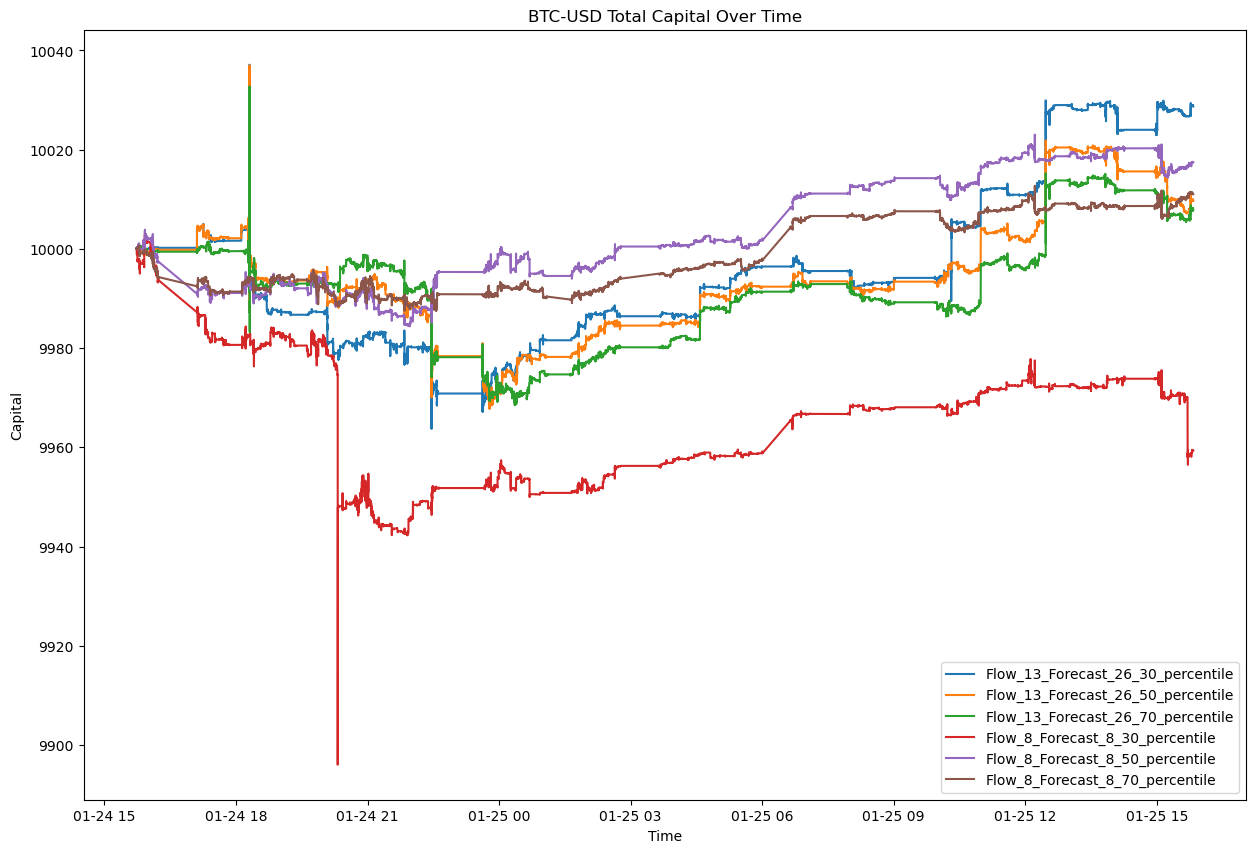

In [36]:
plt.figure(figsize=(15, 10))
for placeholder, df in strategy.tick_performance_tracker['BTC-USD'].items():
    plt.plot(df['date'], df['capital'], label=placeholder)
plt.title('BTC-USD Total Capital Over Time')
plt.xlabel('Time')
plt.ylabel('Capital')
plt.legend()
plt.show()

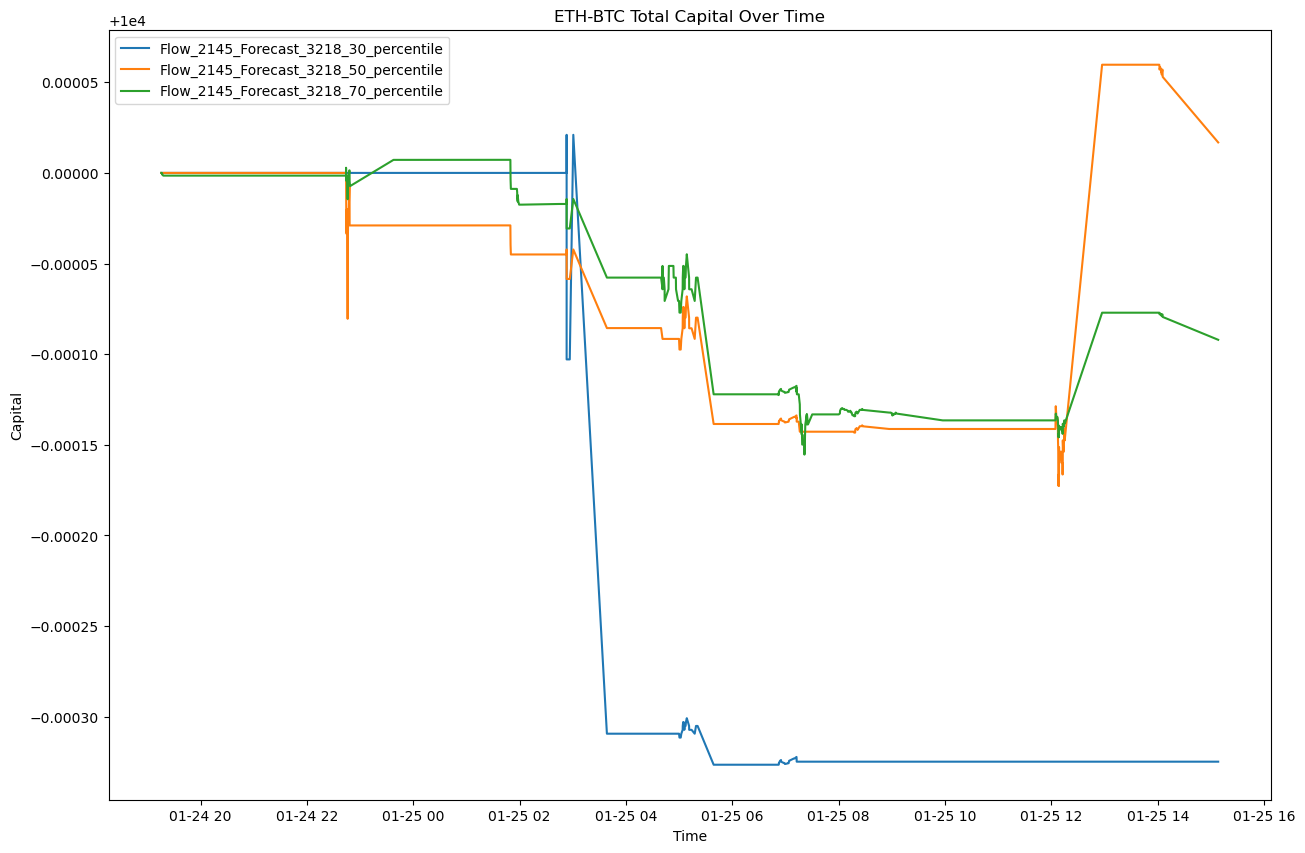

In [37]:
plt.figure(figsize=(15, 10))
for placeholder, df in strategy.tick_performance_tracker['ETH-BTC'].items():
    plt.plot(df['date'], df['capital'], label=placeholder)
plt.title('ETH-BTC Total Capital Over Time')
plt.xlabel('Time')
plt.ylabel('Capital')
plt.legend()
plt.show()

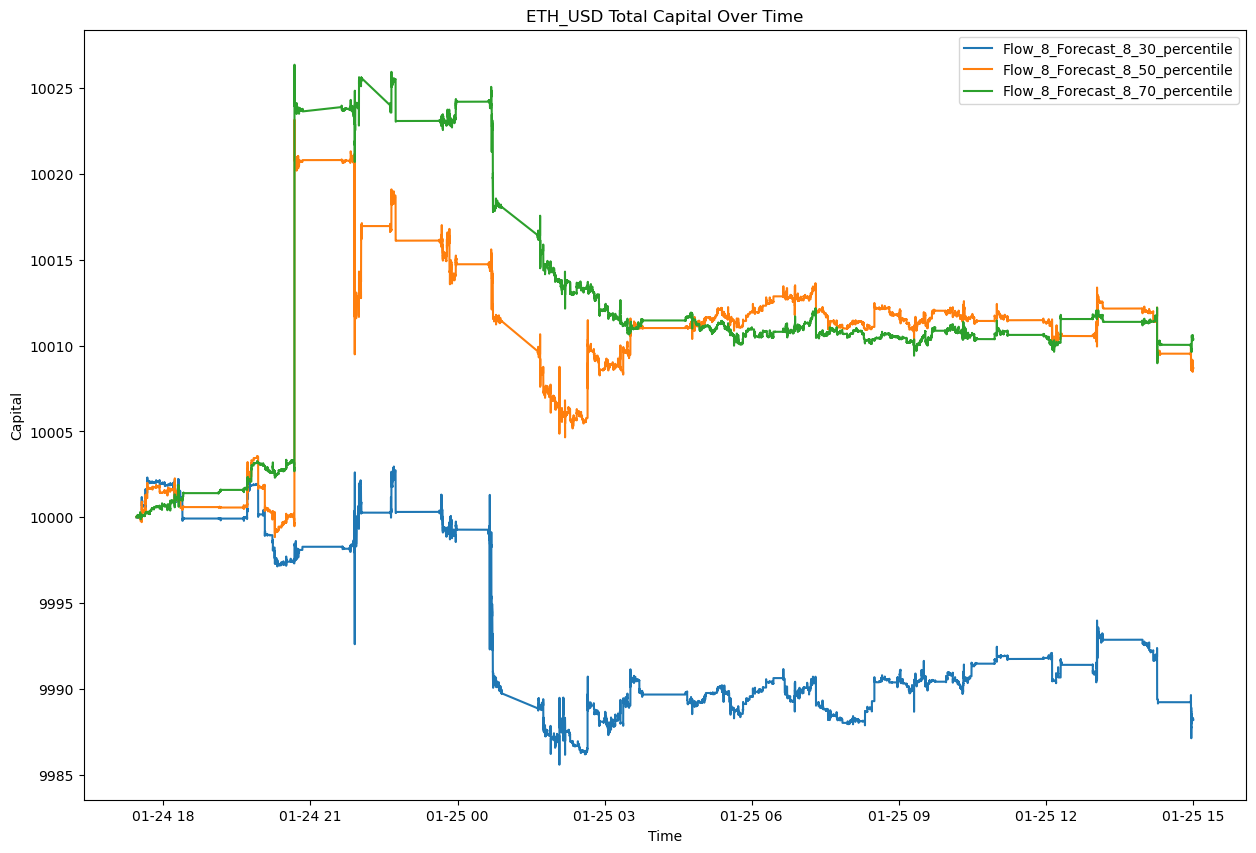

In [38]:
plt.figure(figsize=(15, 10))
for placeholder, df in strategy.tick_performance_tracker['ETH-USD'].items():
    plt.plot(df['date'], df['capital'], label=placeholder)
plt.title('ETH_USD Total Capital Over Time')
plt.xlabel('Time')
plt.ylabel('Capital')
plt.legend()
plt.show()

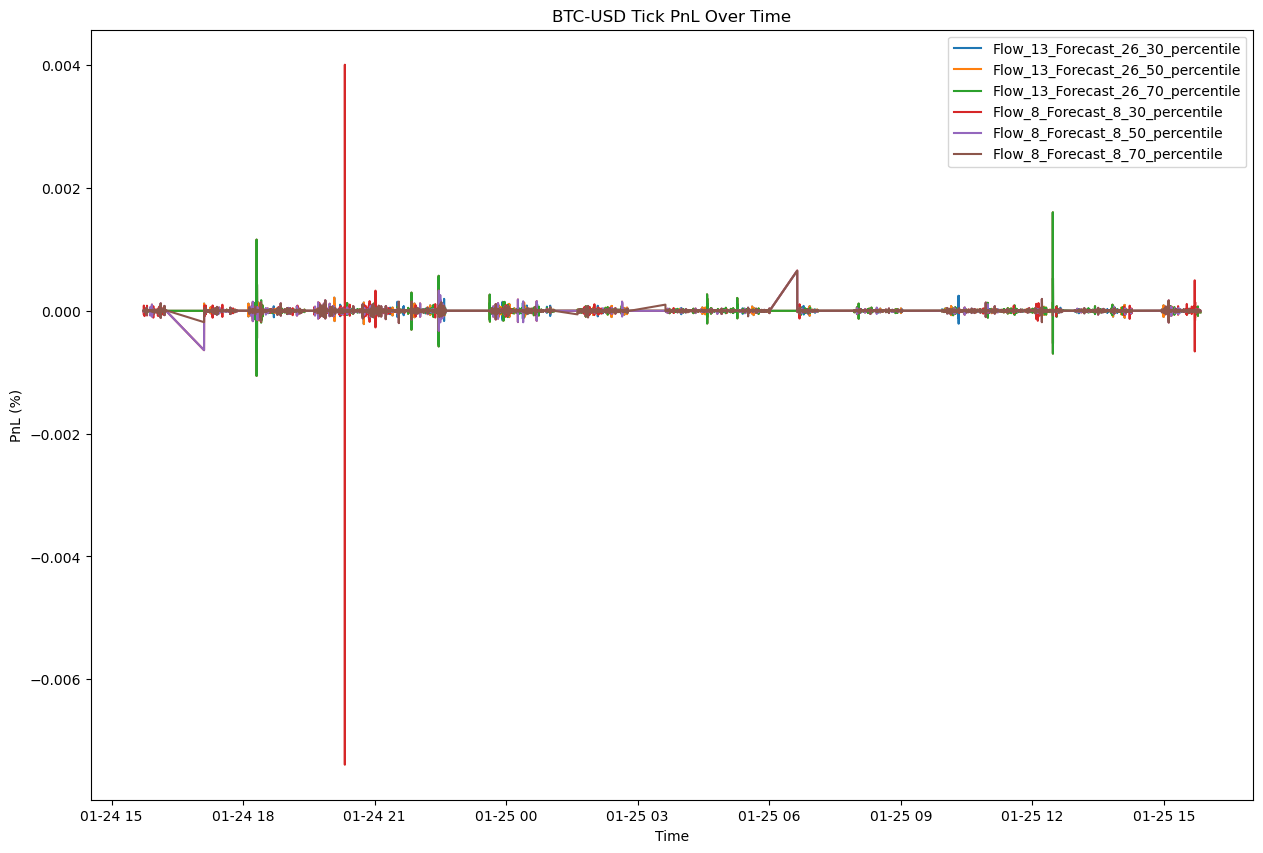

In [39]:
plt.figure(figsize=(15, 10))
for placeholder, df in strategy.tick_performance_tracker['BTC-USD'].items():
    plt.plot(df['date'], df['capital'].pct_change(), label=placeholder)
plt.title('BTC-USD Tick PnL Over Time')
plt.xlabel('Time')
plt.ylabel('PnL (%)')
plt.legend()
plt.show()

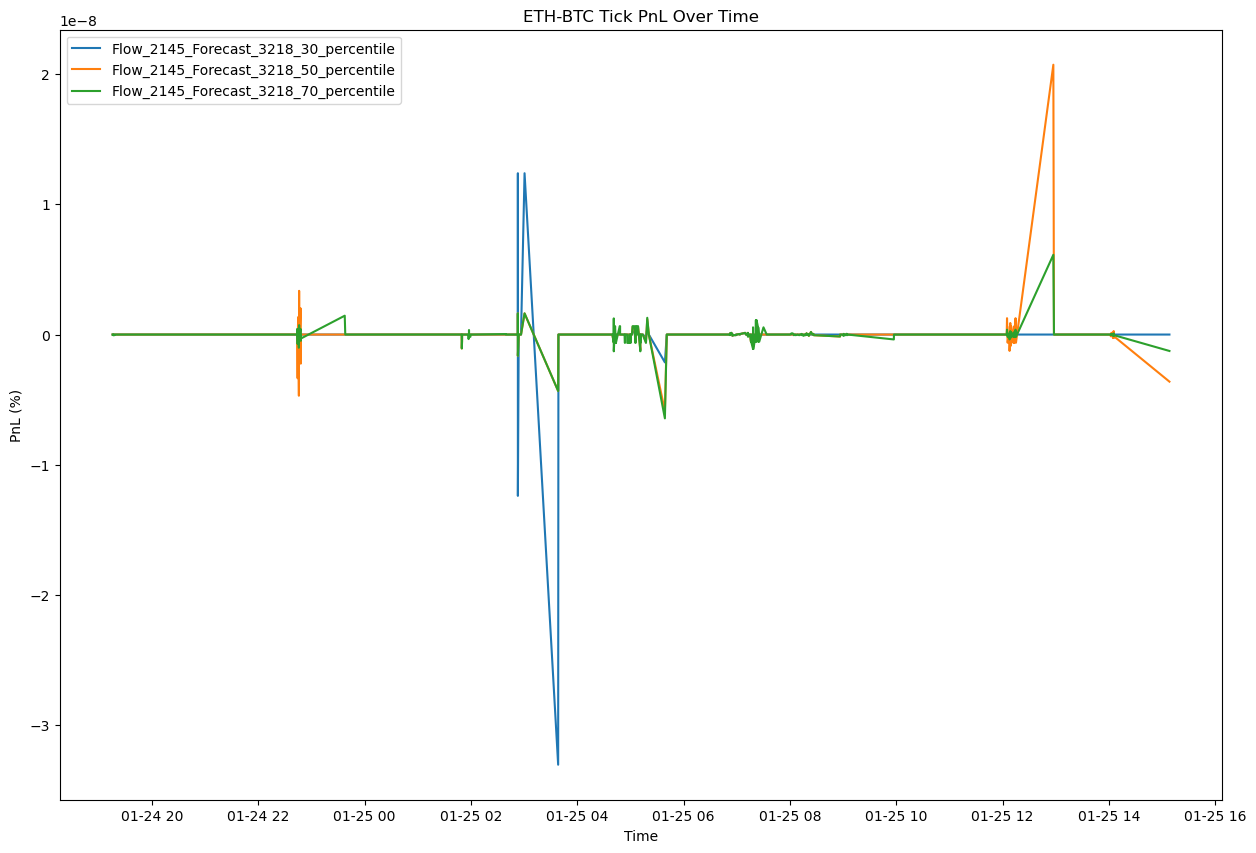

In [40]:
plt.figure(figsize=(15, 10))
for placeholder, df in strategy.tick_performance_tracker['ETH-BTC'].items():
    plt.plot(df['date'], df['capital'].pct_change(), label=placeholder)
plt.title('ETH-BTC Tick PnL Over Time')
plt.xlabel('Time')
plt.ylabel('PnL (%)')
plt.legend()
plt.show()

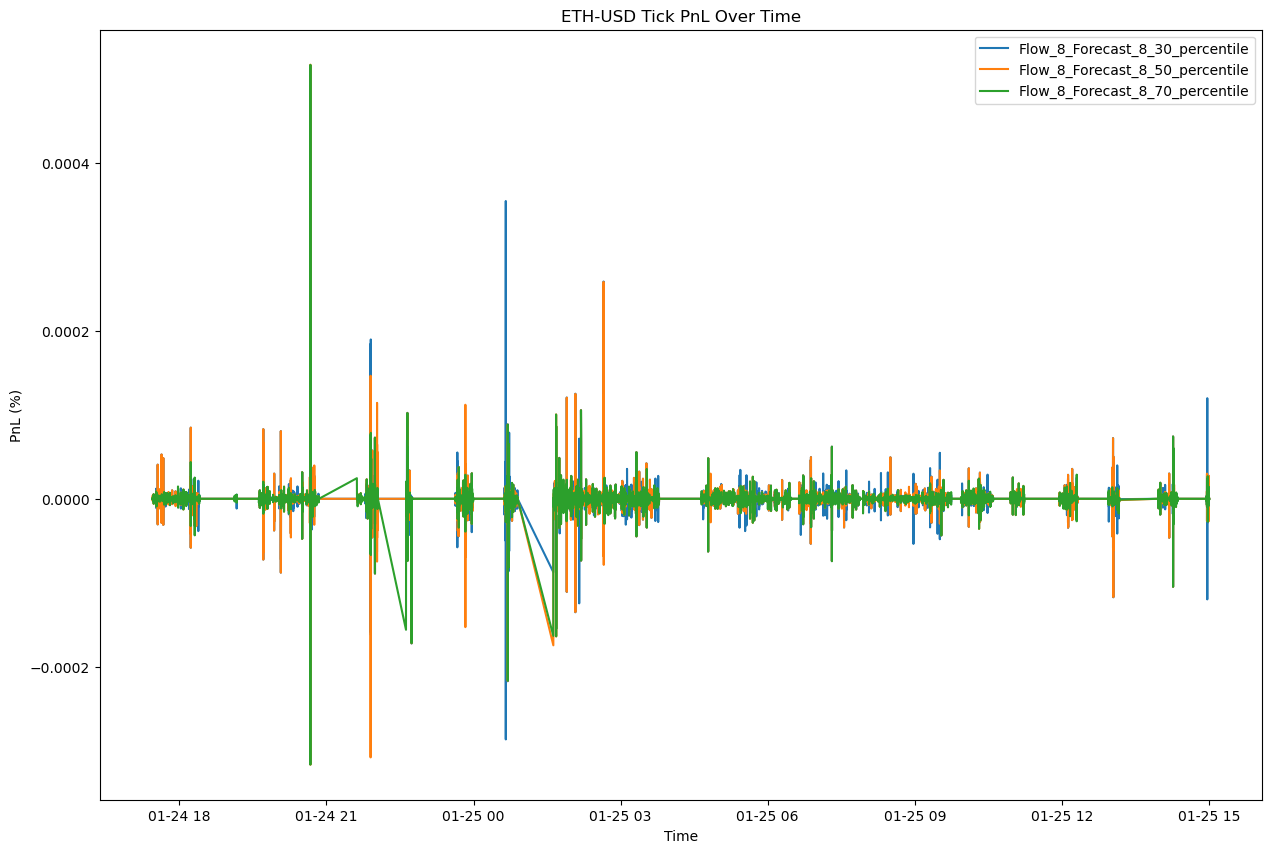

In [41]:
plt.figure(figsize=(15, 10))
for placeholder, df in strategy.tick_performance_tracker['ETH-USD'].items():
    plt.plot(df['date'], df['capital'].pct_change(), label=placeholder)
plt.title('ETH-USD Tick PnL Over Time')
plt.xlabel('Time')
plt.ylabel('PnL (%)')
plt.legend()
plt.show()

# Analysis

In [42]:
eth_usd_tick_perf_resample = {}
for placeholder, df in strategy.tick_performance_tracker['ETH-USD'].items():
    df = df.set_index('date')
    resampled_df = df.resample('3600S').first().interpolate(method='linear')
    resampled_df['hourly_pnl'] = resampled_df['capital'].pct_change()
    eth_usd_tick_perf_resample[placeholder] = resampled_df

In [43]:
btc_usd_tick_perf_resample = {}
for placeholder, df in strategy.tick_performance_tracker['BTC-USD'].items():
    df = df.set_index('date')
    resampled_df = df.resample('3600S').first().interpolate(method='linear')
    resampled_df['hourly_pnl'] = resampled_df['capital'].pct_change()
    btc_usd_tick_perf_resample[placeholder] = resampled_df

In [44]:
eth_btc_tick_perf_resample = {}
for placeholder, df in strategy.tick_performance_tracker['ETH-BTC'].items():
    df = df.set_index('date')
    resampled_df = df.resample('3600S').first().interpolate(method='linear')
    resampled_df['hourly_pnl'] = resampled_df['capital'].pct_change()
    eth_btc_tick_perf_resample[placeholder] = resampled_df

In [45]:
def performance_summary(return_data, annualization = 12):
    """ 
        Returns the Performance Stats for given set of returns
        Inputs: 
            return_data - DataFrame with Date index and Monthly Returns for different assets/strategies.
        Output:
            summary_stats - DataFrame with annualized mean return, vol, sharpe ratio. Skewness, Excess Kurtosis, Var (0.5) and
                            CVaR (0.5) and drawdown based on monthly returns. 
    """
    summary_stats = return_data.mean().to_frame('Mean').apply(lambda x: x*annualization)
    summary_stats['Volatility'] = return_data.std().apply(lambda x: x*np.sqrt(annualization))
    summary_stats['Sharpe Ratio'] = summary_stats['Mean']/summary_stats['Volatility']

    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['VaR (0.05)'] = return_data.quantile(.05, axis = 0)
    summary_stats['CVaR (0.05)'] = return_data[return_data <= return_data.quantile(.05, axis = 0)].mean()
    
    wealth_index = 1000*(1+return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date
    
    return summary_stats

In [51]:
strategy.tick_performance_tracker['ETH-BTC']['Flow_2145_Forecast_3218_30_percentile']

,date,capital
0,2023-01-24 19:15:48.747246,10000.000000
1,2023-01-24 19:15:48.789907,10000.000000
2,2023-01-24 19:16:12.942213,10000.000000
3,2023-01-24 19:16:17.052452,10000.000000
4,2023-01-24 19:16:30.372638,10000.000000
...,...,...
1025,2023-01-25 14:04:21.711402,9999.999675
1026,2023-01-25 14:05:11.218416,9999.999675
1027,2023-01-25 14:05:19.920967,9999.999675
1028,2023-01-25 14:05:28.160664,9999.999675


In [63]:
eth_usd_tick_perf_resample

{'Flow_8_Forecast_8_30_percentile':                           capital  hourly_pnl
 date                                         
 2023-01-24 17:00:00  10000.000000         NaN
 2023-01-24 18:00:00  10001.954628    0.000195
 2023-01-24 19:00:00   9999.923488   -0.000203
 2023-01-24 20:00:00  10000.162378    0.000024
 2023-01-24 21:00:00   9998.277678   -0.000188
 2023-01-24 22:00:00  10001.880256    0.000360
 2023-01-24 23:00:00  10000.306756   -0.000157
 2023-01-25 00:00:00   9999.270876   -0.000104
 2023-01-25 01:00:00   9988.867099   -0.001040
 2023-01-25 02:00:00   9986.887261   -0.000198
 2023-01-25 03:00:00   9988.289193    0.000140
 2023-01-25 04:00:00   9989.667386    0.000138
 2023-01-25 05:00:00   9989.306069   -0.000036
 2023-01-25 06:00:00   9989.557540    0.000025
 2023-01-25 07:00:00   9989.856393    0.000030
 2023-01-25 08:00:00   9987.976909   -0.000188
 2023-01-25 09:00:00   9990.629068    0.000266
 2023-01-25 10:00:00   9990.912500    0.000028
 2023-01-25 11:00:00   99

In [65]:
eth_btc_perf_summary = []
for placeholder, df in eth_btc_tick_perf_resample.items():
    summary_df = performance_summary(df[['hourly_pnl']])
    
    # Add a column or set the DataFrame's name to the key for identification
    summary_df['ETH-BTC Strategy'] = placeholder
    
    # Append the summary DataFrame to the list
    eth_btc_perf_summary.append(summary_df)

eth_btc_perf_summary = pd.concat(eth_btc_perf_summary, axis=0)
eth_btc_perf_summary.set_index('ETH-BTC Strategy', inplace=True)

eth_btc_perf_summary

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recovery
ETH-BTC Strategy,,,,,,,,,,,
Flow_2145_Forecast_3218_30_percentile,-1.948629e-08,2.569409e-08,-0.758396,0.0,0.0,-3.074134e-09,-3.303508e-08,-3.474621e-08,2023-01-25 03:00:00,2023-01-25 06:00:00,NaT
Flow_2145_Forecast_3218_50_percentile,1.009118e-09,1.723683e-08,0.058544,0.0,0.0,-4.288614e-09,-4.337052e-09,-1.427523e-08,2023-01-24 20:00:00,2023-01-25 08:00:00,2023-01-25 13:00:00
Flow_2145_Forecast_3218_70_percentile,-5.523291e-09,7.316030e-09,-0.754957,0.0,0.0,-4.345508e-09,-4.506167e-09,-1.436973e-08,2023-01-24 23:00:00,2023-01-25 10:00:00,NaT


In [67]:
eth_usd_perf_summary = []
for placeholder, df in eth_usd_tick_perf_resample.items():
    summary_df = performance_summary(df[['hourly_pnl']])
    
    # Add a column or set the DataFrame's name to the key for identification
    summary_df['ETH-USD Strategy'] = placeholder
    
    # Append the summary DataFrame to the list
    eth_usd_perf_summary.append(summary_df)

eth_usd_perf_summary = pd.concat(eth_usd_perf_summary, axis=0)
eth_usd_perf_summary.set_index('ETH-USD Strategy', inplace=True)

eth_usd_perf_summary

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recovery
ETH-USD Strategy,,,,,,,,,,,
Flow_8_Forecast_8_30_percentile,-0.000643,0.000995,-0.646123,-1.951930,6.044521,-0.000434,-0.000743,-0.001506,2023-01-24 18:00:00,2023-01-25 02:00:00,NaT
Flow_8_Forecast_8_50_percentile,0.000477,0.001653,0.288384,2.841273,11.812620,-0.000497,-0.000584,-0.001421,2023-01-24 21:00:00,2023-01-25 02:00:00,NaT
Flow_8_Forecast_8_70_percentile,0.000569,0.001710,0.332871,3.375380,15.167146,-0.000259,-0.000518,-0.001478,2023-01-24 22:00:00,2023-01-25 15:00:00,NaT


In [69]:
btc_usd_perf_summary = []
for placeholder, df in btc_usd_tick_perf_resample.items():
    summary_df = performance_summary(df[['hourly_pnl']])
    
    # Add a column or set the DataFrame's name to the key for identification
    summary_df['BTC-USD Strategy'] = placeholder
    
    # Append the summary DataFrame to the list
    btc_usd_perf_summary.append(summary_df)

btc_usd_perf_summary = pd.concat(btc_usd_perf_summary, axis=0)
btc_usd_perf_summary.set_index('BTC-USD Strategy', inplace=True)

btc_usd_perf_summary

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recovery
BTC-USD Strategy,,,,,,,,,,,
Flow_13_Forecast_26_30_percentile,0.001209,0.002457,0.492314,0.800605,2.248409,-0.000873,-0.001182,-0.003080,2023-01-24 18:00:00,2023-01-24 23:00:00,2023-01-25 11:00:00
Flow_13_Forecast_26_50_percentile,0.000772,0.002125,0.363523,1.075645,2.665246,-0.000809,-0.000910,-0.003044,2023-01-24 18:00:00,2023-01-25 00:00:00,2023-01-25 11:00:00
Flow_13_Forecast_26_70_percentile,0.000562,0.002010,0.279686,0.688058,3.559622,-0.000630,-0.000978,-0.002746,2023-01-24 18:00:00,2023-01-25 00:00:00,2023-01-25 13:00:00
Flow_8_Forecast_8_30_percentile,-0.001302,0.002687,-0.484654,-2.843511,9.847284,-0.001306,-0.002264,-0.005570,2023-01-24 16:00:00,2023-01-24 22:00:00,NaT
Flow_8_Forecast_8_50_percentile,0.001004,0.001471,0.682855,-0.447626,2.498886,-0.000445,-0.000778,-0.001637,2023-01-24 16:00:00,2023-01-24 22:00:00,2023-01-25 07:00:00
Flow_8_Forecast_8_70_percentile,0.000452,0.000956,0.473135,0.590216,3.458947,-0.000306,-0.000481,-0.001028,2023-01-24 16:00:00,2023-01-24 22:00:00,2023-01-25 07:00:00


# Conclusion

Overall while my trading strategies did not perform very well I branched out in creating algorithmic ways to determine parameters and testing more parameters overall. My file crashed as I was running the performance summary so I am unsure what my sharpe and other metrics look like but based on the PnL graphs I saw before it crashed there seemed to be alot of variability across the trading strategies. The ETH-BTC pair ad far less frequent tick data than the others so the intervals I was calculating forward return and trade flow on were very high especially when compared to the interval size of the other 2 crypto pairs. In the future I would like to look into a more optimized approach to finding the best interval size and j value such as running an algorithm to maximize the R^2 and maximize potential gains over the test interval for j. In all but one case having a j that was a higher percentile in the training data set outperformed having a lower j. This shows that for this strategy it seems that having a higher threshhold where you start to believe your forecast is more desireable.